# Result

## Dependencies

In [369]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Constant

In [370]:
DATASET_PATH = os.path.join(os.getcwd(), "dataset.csv")
EVALUATION_PATH = os.path.join(os.getcwd(), "evaluation.csv")
PREDICTION_PATH = os.path.join(os.getcwd(), "prediction.csv")
RESULT_PATH = os.path.join(os.getcwd(), "result.csv")
DISTRIBUTION_PATH = os.path.join(os.getcwd(), "distribution.csv")

## Visualization

### Evaluation

     Model     MAE     MSE      R2
0       RF  0.0076  0.0002  0.9956
1       LR  0.0321  0.0018  0.9497
2       GB  0.0090  0.0002  0.9943
3      SVR  0.0318  0.0015  0.9583
4  XGBoost  0.0048  0.0000  0.9988


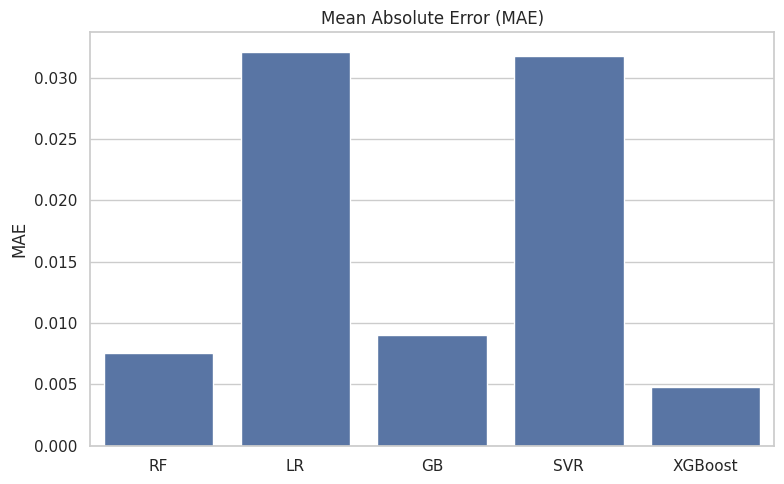

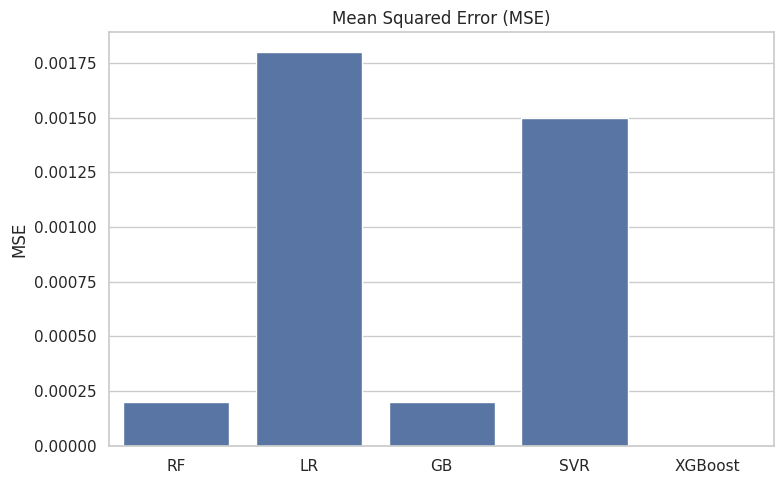

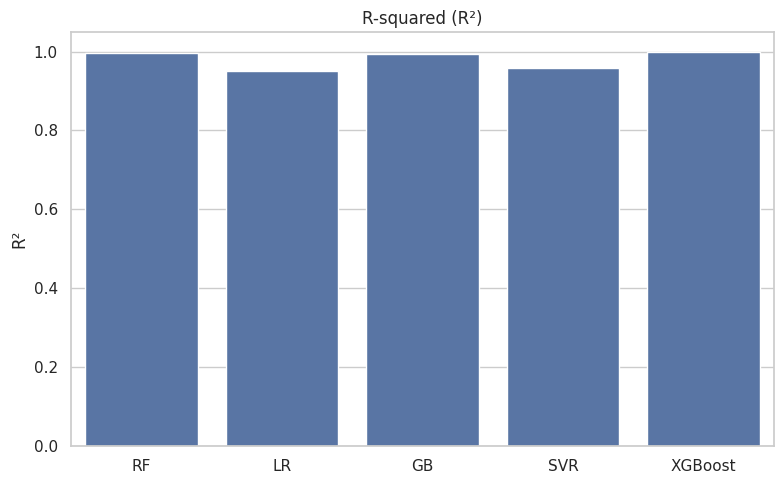

In [371]:
# Load DataFrame
df = pd.read_csv(EVALUATION_PATH)
df["Model"] = df["Model"].replace({
    "Random Forest": "RF",
    "Linear Regression": "LR",
    "Gradient Boosting": "GB",
    "Support Vector Regression": "SVR",
    "XGBoost Regressor": "XGBoost"
})
# Round values to 4 decimal places
df = df.round(4)
print(df)

# Set plot style
sns.set_theme(style="whitegrid")

# Plot MAE
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="MAE", data=df)
plt.title("Mean Absolute Error (MAE)")
plt.ylabel("MAE")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot MSE
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="MSE", data=df)
plt.title("Mean Squared Error (MSE)")
plt.ylabel("MSE")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot R²
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="R2", data=df)
plt.title("R-squared (R²)")
plt.ylabel("R²")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Prediction

Bin           < 40    40 - 60    60 - 80       > 80
Actual   11.570494  32.302201  29.060083  27.067222
RF       11.451517  32.480666  29.030339  27.037478
LR        8.806903  39.452544  25.766141  25.974412
GB       11.392029  32.510410  29.089827  27.007733
SVR       8.387864  39.886972  28.941106  22.784057
XGBoost  11.748959  32.064247  29.060083  27.126710


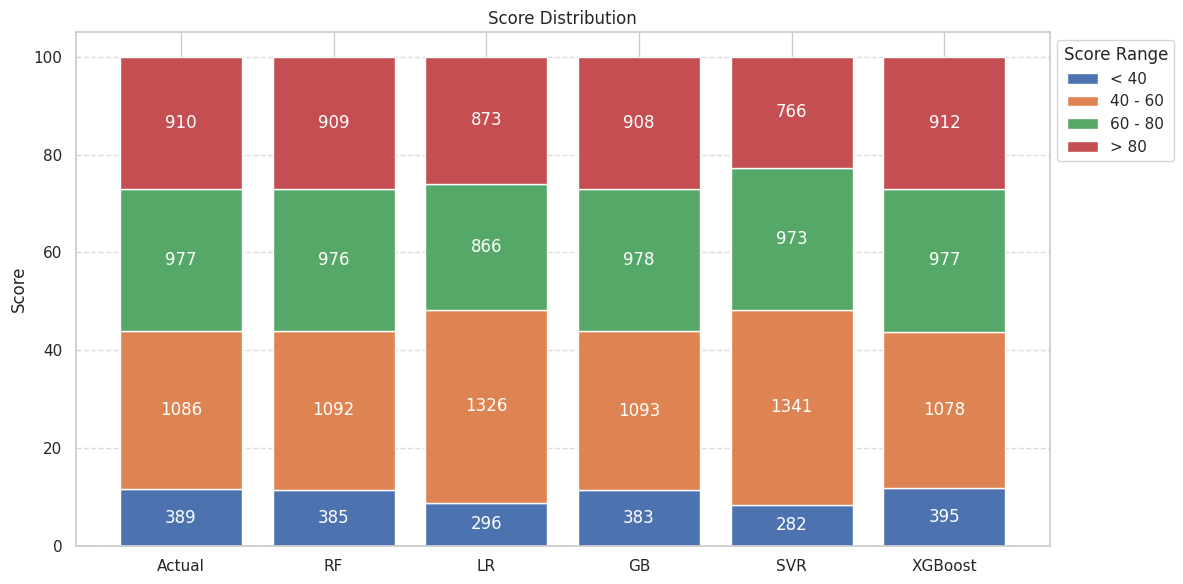

In [372]:
# Load prediction data
df = pd.read_csv(PREDICTION_PATH)
df["Model"] = df["Model"].replace({
    "Random Forest": "RF",
    "Linear Regression": "LR",
    "Gradient Boosting": "GB",
    "Support Vector Regression": "SVR",
    "XGBoost Regressor": "XGBoost"
})

# Ensure Repo ID is treated as string
df["Repo ID"] = df["Repo ID"].astype(str)

# Convert scores to percentage scale
df["Actual Score"] = (df["Actual Score"] * 100).round(0)
df["Predicted Score"] = (df["Predicted Score"] * 100).round(0)

# Define bins and labels
bins = [0, 40, 60, 80, 100]
labels = ["< 40", "40 - 60", "60 - 80", "> 80"]

# Bin actual scores (only once per Repo)
actual_df = df.drop_duplicates(subset="Repo ID").copy()
actual_df.loc[:, "Bin"] = pd.cut(actual_df["Actual Score"], bins=bins, labels=labels, include_lowest=True)
actual_counts = actual_df["Bin"].value_counts(normalize=True).sort_index() * 100

# Bin predicted scores per model
model_names = df["Model"].unique()
model_distributions = {"Actual": actual_counts}

for model in model_names:
    model_df = df[df["Model"] == model].copy()
    model_df.loc[:, "Bin"] = pd.cut(model_df["Predicted Score"], bins=bins, labels=labels, include_lowest=True)
    model_counts = model_df["Bin"].value_counts(normalize=True).sort_index() * 100
    model_distributions[model] = model_counts

# Convert to DataFrame for plotting
dist_df = pd.DataFrame(model_distributions).T[labels]
print(dist_df)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Create bottom for stacking
bottom = pd.Series([0] * len(dist_df), index=dist_df.index)

# Loop through each bin/score range
for label in labels:
    values = dist_df[label]
    bars = ax.bar(dist_df.index, values, bottom=bottom, label=label)

    # Add count label (convert from % to approximate count)
    total_repos = len(actual_df)
    for rect, value in zip(bars, values):
        if value > 0:
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + height / 2,
                f"{int(round(value * total_repos / 100))}",  # approximate count
                ha='center',
                va='center',
                fontsize=12,
                color='white'
            )

    bottom += values

# Final touches
ax.set_ylabel("Score")
ax.set_title("Score Distribution")
ax.legend(title="Score Range", bbox_to_anchor=(1, 1), loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Data

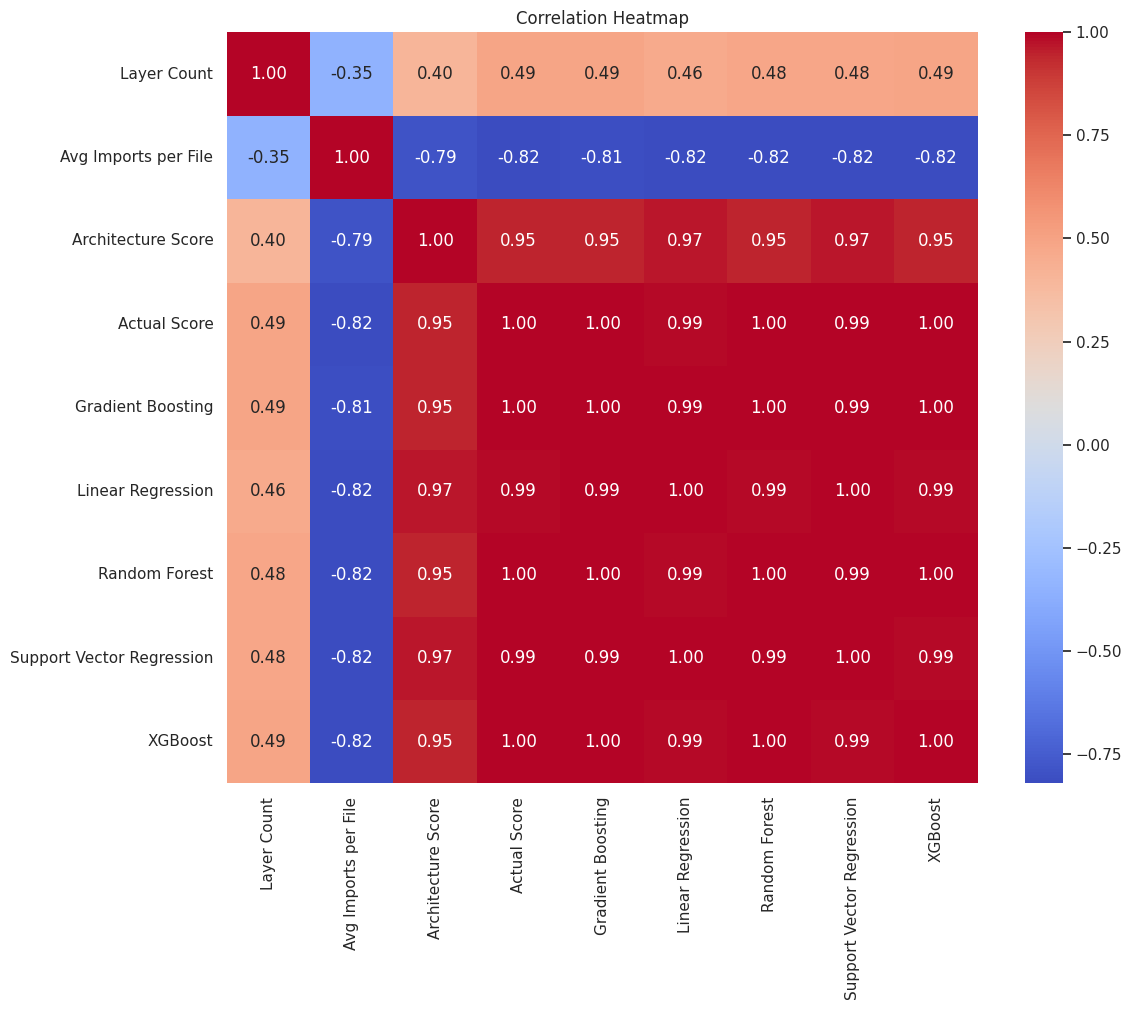

In [373]:
# Load dataset and prediction data
dataset_df = pd.read_csv(DATASET_PATH)
prediction_df = pd.read_csv(PREDICTION_PATH)

# Transpose Repo ID per row
prediction_df = prediction_df.pivot_table(index="Repo ID", columns="Model", values=["Actual Score", "Predicted Score"]).reset_index()
prediction_df.columns = [' '.join(col).strip(' ') for col in prediction_df.columns.values]

# Merge with dataset
df = pd.merge(dataset_df, prediction_df, left_on="ID", right_on="Repo ID", how="left")

# Drop unnecessary columns
df.drop(columns=[
    "Owner", "Name", "Description", "URL", "Stars", "Watch Count", "Fork Count",
    "Issues Open", "Subscriber Count", "Has Domain", "Has Application",
    "Has Interfaces", "Has Infrastructure", "Repo ID"
    ], inplace=True)
df["Actual Score"] = df["Actual Score Random Forest"]
df.drop(columns=[
    "Actual Score Gradient Boosting", "Actual Score Linear Regression",
    "Actual Score Support Vector Regression", "Actual Score XGBoost Regressor",
    "Actual Score Random Forest"
], inplace=True)
df.rename(columns={
    "Predicted Score Gradient Boosting": "Gradient Boosting",
    "Predicted Score Linear Regression": "Linear Regression",
    "Predicted Score Random Forest": "Random Forest",
    "Predicted Score Support Vector Regression": "Support Vector Regression",
    "Predicted Score XGBoost Regressor": "XGBoost"
}, inplace=True)

# Reorder columns: place "Actual Score" after "Avg Effort"
columns = df.columns.tolist()
columns.remove("Actual Score")
columns.insert(columns.index("Avg Effort") + 1, "Actual Score")
df = df[columns]

# Convert all actual scores and model scores to a 0-100 scale
score_columns = ["Actual Score", "Gradient Boosting", "Linear Regression", "Random Forest", "Support Vector Regression", "XGBoost"]
df[score_columns] = df[score_columns] * 100

# Save the final DataFrame to CSV
df.to_csv(RESULT_PATH, index=False)

# Round all numeric values to 2 decimal places
df = df.round(2)

# Display the first few rows of the final DataFrame
df.head()

# Order by Actual Score descending
df = df.sort_values(by="Actual Score", ascending=False)

# Filter and get the first 3 rows for each Actual Score criteria
filtered_df = pd.concat([
    df[df["Actual Score"] < 40].head(3),
    df[(df["Actual Score"] >= 40) & (df["Actual Score"] < 60)].head(3),
    df[(df["Actual Score"] >= 60) & (df["Actual Score"] < 80)].head(3),
    df[df["Actual Score"] >= 80].head(3)
])

# Display the filtered DataFrame
filtered_df.sort_values(by="Actual Score", ascending=False)

# Korelasi antar kolom
arch_corr = filtered_df.drop(columns=[
    "ID", "Total Files", "Size", "Avg Cyclomatic", "Avg Volume", "Avg Difficulty", "Avg Effort"
    ]).corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(arch_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [374]:
# Load prediction data
df = pd.read_csv(PREDICTION_PATH)
df["Model"] = df["Model"].replace({
    "Random Forest": "RF",
    "Linear Regression": "LR",
    "Gradient Boosting": "GB",
    "Support Vector Regression": "SVR",
    "XGBoost Regressor": "XGBoost"
})

# Ensure Repo ID is treated as string
df["Repo ID"] = df["Repo ID"].astype(str)

# Convert scores to percentage scale
df["Actual Score"] = (df["Actual Score"] * 100).round(0)
df["Predicted Score"] = (df["Predicted Score"] * 100).round(0)

# Create a DataFrame to count bin occurrences
bins = [0, 40, 60, 80, 100]
labels = ["Bad", "Average", "Good", "Excellent"]
# Bin actual scores (only once per Repo)
actual_df = df.drop_duplicates(subset="Repo ID").copy()
actual_df.loc[:, "Bin"] = pd.cut(actual_df["Actual Score"], bins=bins, labels=labels, include_lowest=True)
actual_counts = actual_df["Bin"].value_counts().sort_index()
# Bin predicted scores per model
model_names = df["Model"].unique()
model_distributions = {"Actual": actual_counts}
for model in model_names:
    model_df = df[df["Model"] == model].copy()
    model_df.loc[:, "Bin"] = pd.cut(model_df["Predicted Score"], bins=bins, labels=labels, include_lowest=True)
    model_counts = model_df["Bin"].value_counts().sort_index()
    model_distributions[model] = model_counts
# Convert to DataFrame for plotting
dist_df = pd.DataFrame(model_distributions).T[labels]
# Print the distribution DataFrame
print(dist_df)
# Save the distribution DataFrame to CSV
dist_df = dist_df.reset_index().rename(columns={"index": "Model"})
dist_df.to_csv(DISTRIBUTION_PATH, index=False)

Bin      Bad  Average  Good  Excellent
Actual   389     1086   977        910
RF       385     1092   976        909
LR       296     1326   866        873
GB       383     1093   978        908
SVR      282     1341   973        766
XGBoost  395     1078   977        912


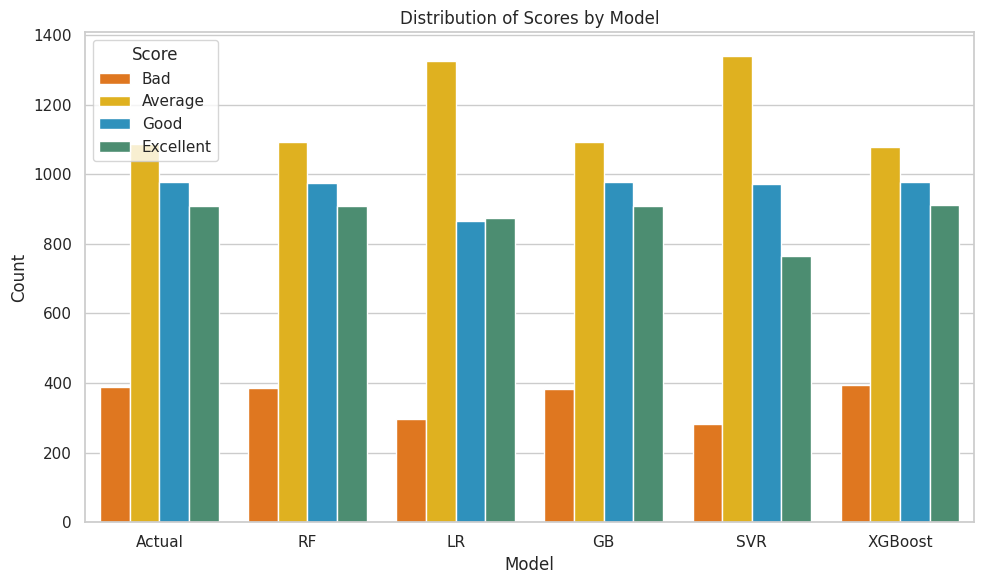

In [375]:
# Load the distribution DataFrame
dist_df = pd.read_csv(DISTRIBUTION_PATH)
# Plotting the distribution of scores
plt.figure(figsize=(10, 6))
palette = {"Bad": "#ff7400", "Average": "#ffc100", "Good": "#189ad3", "Excellent": "#419873"}
sns.barplot(
    data=dist_df.melt(id_vars="Model", var_name="Score Range", value_name="Count"),
    x="Model", y="Count", hue="Score Range", palette=palette
)
plt.title("Distribution of Scores by Model")
plt.xlabel("Model")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Score", loc="upper left")
plt.tight_layout()
plt.show()